# Architecture - Semantic Search using Elastic Search


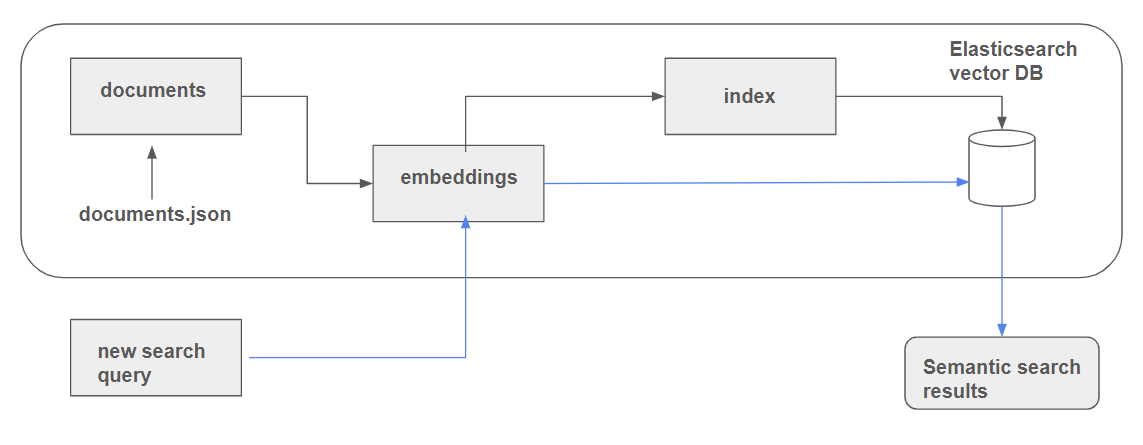

* Two very important concepts in Elasticsearch are documents and indexes.

* A document is collection of fields with their associated values. 

* To work with Elasticsearch you have to organize your data into documents, and then add all your documents to an index. 

* Index as a collection of documents that is stored in a highly optimized format designed to perform efficient searches.

#### Step 1: Prepare documents

In [9]:
import json

with open('documents.json', 'rt') as f_in:
    docs_raw = json.load(f_in)

In [10]:
documents = []

for course_dict in docs_raw:
    for doc in course_dict['documents']:
        doc['course'] = course_dict['course']
        documents.append(doc)

documents[1]

{'text': 'GitHub - DataTalksClub/data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp'}

#### Step 2: Create Embeddings using Pretrained Models

Sentence Transformers documentation here: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

In [11]:
# This is a new library compared to the previous modules. 
# Please perform "pip install sentence_transformers==2.7.0"
from sentence_transformers import SentenceTransformer

# if you get an error do the following:
# 1. Uninstall numpy 
# 2. Uninstall torch
# 3. pip install numpy==1.26.4
# 4. pip install torch
# run the above cell, it should work
model = SentenceTransformer("all-mpnet-base-v2")

In [12]:
len(model.encode("This is a simple sentence"))

768

In [13]:
documents[1]

{'text': 'GitHub - DataTalksClub/data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp'}

It makes sense to do encoding for `text` and `question` fields because `section` and `course` don’t contain a lot of info (categories).

In [5]:
# Create the dense vector using the pre-trained model
operations = []
for doc in documents:
    # Transforming the title into an embedding using the model
    doc["text_vector"] = model.encode(doc["text"]).tolist()
    operations.append(doc)

In [14]:
operations[1]

{'text': 'GitHub - DataTalksClub/data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp',
 'text_vector': [-0.03641175478696823,
  0.020610174164175987,
  -0.04089023545384407,
  -0.0184768233448267,
  -0.018187588080763817,
  0.0165435578674078,
  -0.008730764500796795,
  -0.009902060963213444,
  0.02909734658896923,
  0.012701976113021374,
  0.026511481031775475,
  -0.017969416454434395,
  -0.0016376066487282515,
  0.11685213446617126,
  0.02934090606868267,
  -0.025640184059739113,
  0.026349829509854317,
  0.028250807896256447,
  -0.0853327140212059,
  -0.0016314907697960734,
  -0.013839684426784515,
  0.008223595097661018,
  -0.023533964529633522,
  -0.0379507914185524,
  0.0275421179831028,
  0.016090886667370796,
  -0.021919332444667816,
  0.013490736484527588,
  -0.01617409475147724,
  -0.011982614174485207,
  0.026945531368255615,
  0.04

#### Step 3: Setup ElasticSearch connection 

In [15]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200') 

es_client.info()

ObjectApiResponse({'name': '101b1e51ad16', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'R51OrOC0Ql2qWjl9UujLxw', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

#### Step 4: Create Mappings and Index

* Mapping is defining how a document, and the fields it contains, are stored and indexed.

* Each document is a collection of fields with its own data type.

* We can compare mapping to a database schema in how it describes the fields and properties that documents hold, the data type of each field (e.g., string, integer, or date), and how those fields should be indexed and stored 


#### Settings 
`number_of_shards`: This setting defines the number of primary shards for the index. In this case, it is set to 1, which means the index will have only one primary shard. **Shards** are essentially segments of the index that allow for parallel processing and distribution across nodes.

`number_of_replicas`: This setting defines the number of replica shards for each primary shard. Here, it is set to 0, meaning there will be no replicas. **Replicas** are copies of the primary shards that provide redundancy and high availability.


#### Mappings
**Mappings** define how the documents and their fields are stored and indexed.

`properties`: This section specifies the fields of the documents and their data types.

`text`: This field is of type text, which means it will be analyzed and tokenized for full-text search capabilities.

`section`: This field is also of type text, similar to the text field, allowing for full-text search.

`question`: This field is of type text, enabling full-text search on questions.

`course`: This field is of type keyword, which means it will be stored as-is and not analyzed. It is suitable for structured data like identifiers, tags, or categories.

`text_vector`: This field is of type dense_vector, which is used to store high-dimensional vectors. The settings for this field are:
dims: Specifies the number of dimensions for the vector, set to 768 in this case. This is typical for embeddings generated by models like BERT.


`index`: Set to True, indicating that *the vector should be indexed for efficient similarity search*.

`similarity`: Set to `cosine`, specifying that cosine similarity will be used to measure the similarity between vectors.

In [16]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} ,
            "text_vector": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"},
        }
    }
}

in case you want to update the dataset, you need to delete `index_name` first

In [17]:
index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

#### Step 5: Add documents into index

In [18]:
for doc in operations:
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

#### Step 6: Create end user query

In [19]:
search_term = "windows or mac?"
vector_search_term = model.encode(search_term)

In [20]:
query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000, 
}

`field`: `text_vector`: This specifies the field in the Elasticsearch index that contains the vector representations of the documents. 

`query_vector`: encoded query.


`k`: 5. This parameter specifies the **number of nearest neighbors** (most similar documents) to return. In our case, the search will return the top 5 most similar documents to the query vector.

`num_candidates`: 10000. This parameter sets the number of candidate vectors to consider during the approximate kNN search.

The `num_candidates` parameter is important for *balancing search speed and accuracy*. A higher value will consider more candidates, potentially improving accuracy but increasing search time. A lower value will be faster but might miss some relevant results.

In [21]:
# Key-word basic search, scores are between 0 and 1
ноль res = es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course"])
res["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': 'vCxIsZABH1NmjU2WsDip',
  '_score': 0.7147919,
  '_source': {'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'section': 'General course-related questions',
   'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully'}},
 {'_index': 'course-questions',
  '_id': '3CxJsZABH1NmjU2WGDtU',
  '_score': 0.61072737,
  '_source': {'question': 'WSL instructions',
   'course': 'mlops-zoomcamp',
   'section': 'Module 1: Introduction',
   'text': 'If you wish to use WSL on your windows machine, here are the setup instructions:\nCommand: Sudo apt install wget\nGet Anaconda download address here. wget <download address>\nTurn on Docker Desktop WFree Download | AnacondaSL2\nCommand: git clone <github repository address>\nVSCODE on WSL\nJupyter: pip3 install jupyter\nAdded by Gregory Morris (gwm1980@gmail.com)\nAll in all softwares a

#### Step 7: Perform Keyword search with Semantic Search (Hybrid/Advanced Search)

`score` can be more than 1 (scaled, needs more control)

In [22]:
# Note: I made a minor modification to the query shown in the notebook here
# (compare to the one shown in the video)
# Included "knn" in the search query (to perform a semantic search) along with the filter  
knn_query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000
}

In [23]:
response = es_client.search(
    index=index_name,
    query={
        "match": {"section": "General course-related questions"},
    },
    knn=knn_query,
    size=5
)

The `size` parameter is set to 5, which means the search will return a maximum of 5 documents in the response.

The `query` field contains the search criteria used to match documents in the index.
In this case, a `match` query is used, which is a standard full-text query for performing full-text searches.

In [24]:
response["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': 'vCxIsZABH1NmjU2WsDip',
  '_score': 11.313494,
  '_source': {'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully',
   'section': 'General course-related questions',
   'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'text_vector': [-0.026965461671352386,
    -0.000626126304268837,
    -0.01662949100136757,
    0.05285150930285454,
    0.05476527288556099,
    -0.03133990615606308,
    0.029942581430077553,
    -0.04808562621474266,
    0.04467551037669182,
    0.005839474033564329,
    0.016233040019869804,
    0.012001154012978077,
    -0.031222281977534294,
    0.016600528731942177,
    -0.04886901378631592,
    -0.06496307998895645,
    0.046434223651885986,
    -0.009297756478190422,
    -0.0642528235912323,
    -0.01373267825692892,
    -0.015976183116436005,
    0.008629541844129562,
    -0.02447899058461

#### References

1. https://logz.io/blog/elasticsearch-mapping/#:~:text=Within%20a%20search%20engine%2C%20mapping,indexes%20and%20stores%20its%20fields

2. https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

3. https://www.elastic.co/search-labs/tutorials

4. https://www.elastic.co/search-labs/blog/text-similarity-search-with-vectors-in-elasticsearch